# Plot the figures for Hox pareto

To run this script, you need to download and unzip the data backup of the hox pareto [here](https://mcgill-my.sharepoint.com/personal/adrien_henry_mail_mcgill_ca/_layouts/15/guestaccess.aspx?docid=0de6e1444f92d4dd0b215b8b02e27d869&authkey=AQJnMtX33DBz3ERfO9QzdSM).

In [1]:
%matplotlib notebook
import phievo
from phievo.AnalysisTools import Simulation,palette#,plotly_graph
import shelve,os,pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  
mpl.rcParams['font.size'] =20
import numpy as np
import random
import copy
palette.update_default_colormap("tab20c")

In [2]:
choose_seed = "hox_pareto_complete"
directory = "example_hox_pareto_complete"

In [3]:
sim = Simulation(directory)
seed = sim.seeds[choose_seed]
genealogy = sim.get_genealogy(choose_seed)
#genealogy.sort_networks(verbose=True)
networks = genealogy.load_sort_networks()

# Select example networks

In [5]:
net_ind = seed.get_backup_net(16000,43).identifier
ancestors = genealogy.search_ancestors(networks[net_ind])
def surounding_net(ind,nb=1,step=1):
    position = [aa["ind"] for aa in ancestors].index(ind)
    if type(nb)==int:
        return [ancestors[i]["ind"] for i in range(position-nb,position+nb+1,step)]
    elif type(nb)==list:
        return [ancestors[i]["ind"] for i in range(position-nb[0],position+nb[1]+1,step)]
index_net = surounding_net(27655,[3,6],step=1)
index_net_reduced = [ind for i,ind in enumerate(index_net) if i%3==0]
assert len(index_net_reduced)==4
assert index_net_reduced[-1]==index_net[-1]
print("Selected networks: ",index_net)

Selected networks:  [27627, 27630, 27635, 27655, 27666, 27672, 27691, 27703, 27708, 27712]


# Plot all the networks in the fitness space

In [ ]:
generations = list(range(500,16001,50))
col = palette.color_generate(1)[0]
col2 = "#E6550D"
#colors = {i:col for i in generations}
gradient = ['#3182BD', '#31A354',0.5,'#31A354',"#D62728"]
fig = seed.plot_pareto_fronts(generations,gradient=gradient,s=1,xlabel=r"$-F_1$",ylabel=r"$F_2$",no_popup=True)
ax = fig.axes[0]
axins = zoomed_inset_axes(ax, 3, loc=1)  # zoom = 6
print(len(ax.collections))
F1 = []
F2 = []
F1_red = []
F2_red = []
for ind in index_net:
    F1.append(networks[ind]["fit"][0])
    F2.append(networks[ind]["fit"][1])
    if ind in index_net_reduced:
        F1_red.append(F1[-1])
        F2_red.append(F2[-1])
ax.plot(F1,F2,linestyle='-', marker='o',lw=2,color=col2,ms=1)
ax.scatter(F1_red,F2_red,color=col2,s=12)
ax.set_xlim(-2.4, 0.05)
ax.set_ylim(0, 2)
#remove axis
#ax.axis('off')    
# sub region of the original image
x1, x2, y1, y2 = -2.2,-2,0.78,1.1
for collect in ax.collections:
    col = collect._original_facecolor
    data = collect.get_offsets()
    data = data[np.apply_along_axis(lambda x: x1<x[0]<x2 and y1<x[1]<y2,1,data),:]
    if len(data):
        axins.scatter(data[:,0],data[:,1],color=col,s=1)
axins.plot(F1,F2,linestyle='-', marker='o',lw=2,color=col2,ms=1)
axins.scatter(F1_red,F2_red,color=col2,s=12)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# fix the number of ticks on the inset axes
axins.yaxis.get_major_locator().set_params(nbins=7)
axins.xaxis.get_major_locator().set_params(nbins=7)
plt.xticks(visible=False)
plt.yticks(visible=False)
# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
ax1 = fig.add_axes([0.91, 0.11, 0.01, 0.77])
norm = mpl.colors.Normalize(vmin=min(generations)/1000, vmax=max(generations)/1000)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=palette.make_colormap(gradient),norm=norm,orientation='vertical')
cb1.set_label('Generation/1000')
fig.savefig("fitness_space.svg")

# Plot network profiles

<IPython.core.display.Javascript object>


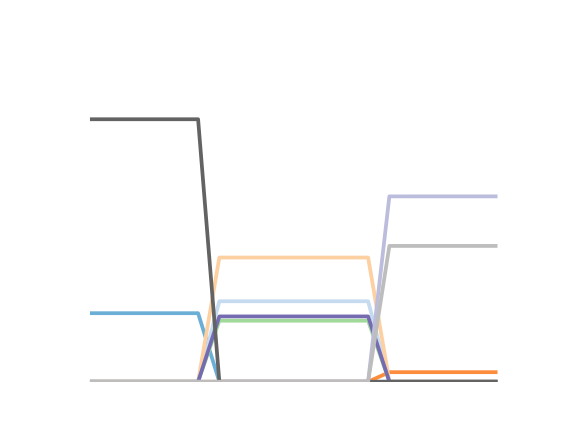

<IPython.core.display.Javascript object>


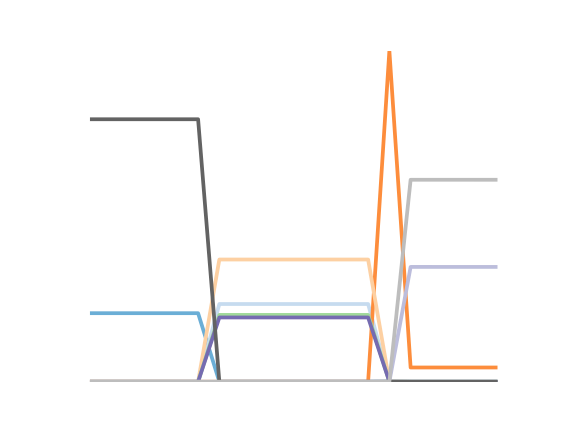

<IPython.core.display.Javascript object>


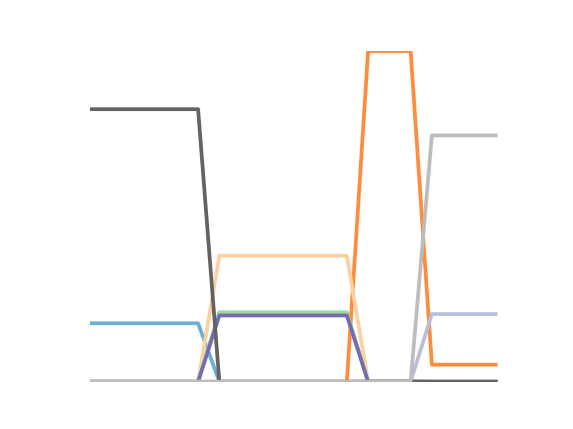

<IPython.core.display.Javascript object>


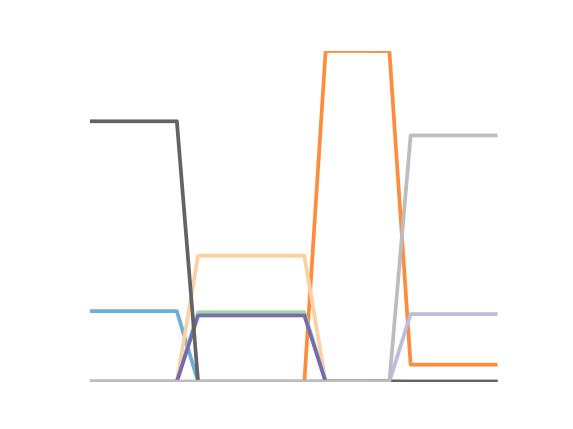

In [6]:
def plot_probability_profile(res):       
    matrix = np.array([res[0][i][-1] for i in res[0].keys()])
    proba = matrix[:,res["outputs"]]
    col = np.array(palette.color_generate(matrix.shape[1]))[res["outputs"]]
    normalization = np.sum(proba,axis=1)
    normalization[normalization==0] = 1
    proba = np.transpose(proba)/normalization
    fig = plt.figure()
    ax = fig.gca()
    ax.set_ylim(0, 1)
    for gen in range(proba.shape[0]):
        ls ="-"
        gen_prob = proba[gen,:]
        ax.plot(gen_prob,lw=3,ls=ls,color=col[gen])        
    ax.axis("off")
    return fig


for i,net_ind in enumerate(index_net_reduced):
    net = genealogy.get_network_from_identifier(net_ind)
    res = sim.run_dynamics(net)
    fig_profile=plot_probability_profile(res)
    fig_profile.axes[0].axis("off")
    fig_profile.savefig("network_profile{}.svg".format(i))      
    del fig_profile

# Mutation fitness deviation

### Generate the perturbations

In [ ]:
mutations = ["random_duplicate()","random_Interaction(\'TFHill\')","mutate_Node(\'TModule\')","mutate_Node(\'Species\')","mutate_Node(\'TFHill\')","random_change_output()","remove_Interaction(\'CorePromoter\')","remove_Interaction(\'TFHill\')","random_gene(\'TF\')"]
mutation_effects = {mut:[] for mut in mutations}
number_points = 300
pop_size = sim.inits.prmt["npopulation"]
print_step = max(int(number_points/100),1)

In [ ]:
with shelve.open(os.path.join(seed.root,"Restart_file")) as backup_data:
    gen_keys = [int(kk) for kk in list(backup_data.dict.keys())]
    for count in range(number_points):
        gen = random.choice(gen_keys)
        pos = random.randint(0,pop_size-1)
        network = backup_data[str(gen)][1][pos]
        fitness = list(network.fitness)
        for mut in mutations:
            net = copy.deepcopy(network)
            getattr(net,mutations[0][:-2])()
            mut_fit =[float(fit) for fit in sim.deriv2.compile_and_integrate(net,sim.inits.prmt,nnetwork=0)]
            delta_fit = [mut_fit[i]-fitness[i] for i in [0,1]]
            mutation_effects[mut].append(delta_fit)
            
        if (count%print_step)==0:
            print("({}/{}) done.".format(count,number_points),end="\r")

pickle.dump(mutation_effects,open(os.path.join(seed.root,"mutation_perturbation.pkl"),"wb"))
print()


### Load existing perturbation results

In [ ]:
mutation_effects = pickle.load(open(os.path.join(seed.root,"mutation_perturbation.pkl"),"rb"))

### Plot

In [ ]:
colors = {mut:col for mut,col in zip(mutation_effects.keys(),palette.color_generate(len(mutation_effects)))}
fig = plt.figure()
#remove axis
#ax.axis('off')
ax = fig.gca()
for mut,deviations in mutation_effects.items():
    xx,yy = zip(*deviations)
    ax.scatter(xx,yy,marker =".",s=10,color=colors[mut])
ax.set_xlabel(r'$-\Delta F_{1}$')
ax.set_ylabel(r'$\Delta F_{2}$')
ax.set_xlim([-1.15,0.3])
ax.set_ylim([-0.2,1.25])
fig.savefig("mutation_effect.svg",dpi=400)